**Applying RNN to Time-Series Data**

Taking weather forecasting data

In [3]:
!pip install tensorflow==2.15

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip      # Loading the data for applying RNN
!unzip jena_climate_2009_2016.csv.zip

--2024-07-19 20:56:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.34.88, 16.182.104.216, 52.217.125.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.34.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.7MB/s    in 0.7s    

2024-07-19 20:57:00 (18.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Importing the dataset

In [5]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")  # This is the file

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)     # Printing the initial values
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
import numpy as np
temp = np.zeros((len(lines),))
pmry_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    pmry_data[i, :] = values[:]

**Graph which shows the timeseries of temperatues as we took the weather forecasting dataset**

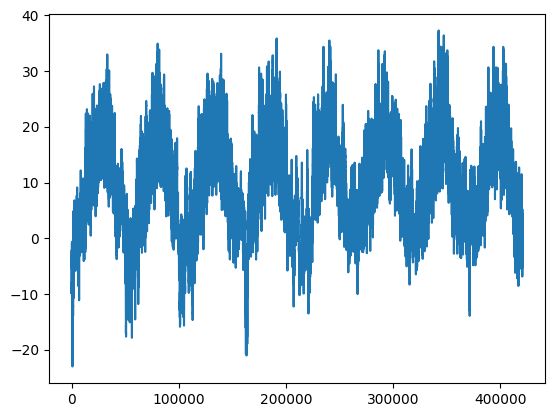

In [7]:
from matplotlib import pyplot as plt # Using matplotlib to plot the values
plt.plot(range(len(temp)), temp)

**Temperatues in °C**

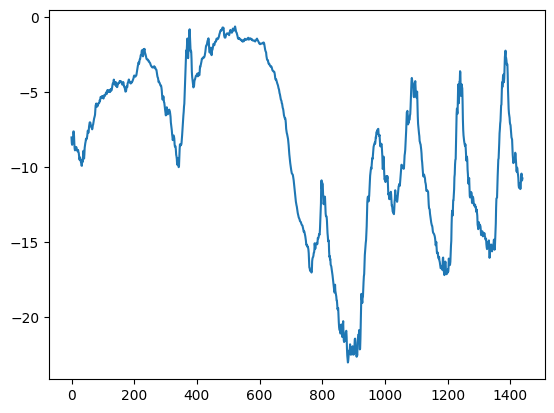

In [8]:
plt.plot(range(1440), temp[:1440])

**Calculating the quantity of samples that each data split will require**

In [9]:
num_train_samples = int(0.5 * len(pmry_data))
num_val_samples = int(0.25 * len(pmry_data))
num_test_samples = len(pmry_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Data Standardization**

Computing the mean and standard deviation on train data

In [10]:
mean = pmry_data[:num_train_samples].mean(axis=0)
pmry_data-= mean
std = pmry_data[:num_train_samples].std(axis=0)
pmry_data/= std

Here we use Numpy array to produce data sets in bulk for time series model training.

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dataset_1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],           # Taking input sequence of length 3
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dataset_1:     # Using for loop to iterate over batches of data
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating training, testing, and validation of datasets**

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    pmry_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Shape of the data chunks**

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**1st Model:**


---


***A common-sense, non-machine-learning baseline***

**Baseline MAE caluculation**

In [14]:
def evaluate_naive_method(dataset): # using evaluate_naive_method to calculate MAE
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") # Displaying the validation MAE
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}") #  # Displaying the validation MAE

Validation MAE: 2.44
Test MAE: 2.62


**2nd Model:**


---


***Basic machine-learning model***

**Simple neural network model for forecasting using Keras.**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 49s 57ms/step - loss: 12.6822 - mae: 2.7610 - val_loss: 13.8029 - val_mae: 2.9586
Epoch 2/5
819/819 [==============================] - 39s 48ms/step - loss: 9.2481 - mae: 2.3869 - val_loss: 12.3963 - val_mae: 2.8054
Epoch 3/5
819/819 [==============================] - 36s 44ms/step - loss: 8.4552 - mae: 2.2838 - val_loss: 10.8290 - val_mae: 2.5845
Epoch 4/5
819/819 [==============================] - 35s 42ms/step - loss: 7.9575 - mae: 2.2182 - val_loss: 10.8120 - val_mae: 2.5948
Epoch 5/5
405/405 [==============================] - 12s 27ms/step - loss: 11.6896 - mae: 2.6934
Test MAE: 2.69


The above model takes as input a sequence of data points and outputs a single value.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 47s 56ms/step - loss: 13.1631 - mae: 2.8186 - val_loss: 10.9407 - val_mae: 2.6052
Epoch 2/5
819/819 [==============================] - 40s 49ms/step - loss: 9.6131 - mae: 2.4498 - val_loss: 10.6815 - val_mae: 2.5800
Epoch 3/5
819/819 [==============================] - 37s 45ms/step - loss: 9.1471 - mae: 2.3879 - val_loss: 10.2776 - val_mae: 2.5247
Epoch 4/5
819/819 [==============================] - 35s 43ms/step - loss: 8.8006 - mae: 2.3431 - val_loss: 10.8628 - val_mae: 2.6094
Epoch 5/5
405/405 [==============================] - 14s 33ms/step - loss: 11.3995 - mae: 2.6581
Test MAE: 2.66


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 37s 44ms/step - loss: 11.7960 - mae: 2.6688 - val_loss: 11.1429 - val_mae: 2.6242
Epoch 2/5
819/819 [==============================] - 45s 54ms/step - loss: 8.6042 - mae: 2.3066 - val_loss: 11.2364 - val_mae: 2.6447
Epoch 3/5
819/819 [==============================] - 35s 43ms/step - loss: 7.7225 - mae: 2.1854 - val_loss: 10.5288 - val_mae: 2.5591
Epoch 4/5
819/819 [==============================] - 36s 44ms/step - loss: 7.1612 - mae: 2.1008 - val_loss: 11.1199 - val_mae: 2.6513
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 11.4643 - mae: 2.6804
Test MAE: 2.68


In [18]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 34s 41ms/step - loss: 12.1653 - mae: 2.7046 - val_loss: 11.5348 - val_mae: 2.6822
Epoch 2/5
819/819 [==============================] - 34s 42ms/step - loss: 8.4944 - mae: 2.2914 - val_loss: 12.2011 - val_mae: 2.7547
Epoch 3/5
819/819 [==============================] - 36s 44ms/step - loss: 7.3859 - mae: 2.1353 - val_loss: 11.1767 - val_mae: 2.6296
Epoch 4/5
819/819 [==============================] - 47s 57ms/step - loss: 6.6551 - mae: 2.0285 - val_loss: 10.7361 - val_mae: 2.5919
Epoch 5/5
405/405 [==============================] - 12s 29ms/step - loss: 11.8821 - mae: 2.7173
Test MAE: 2.72


Tried various dense units of 8, 32 and 64

**Graph of Training and Validation MAE Values**

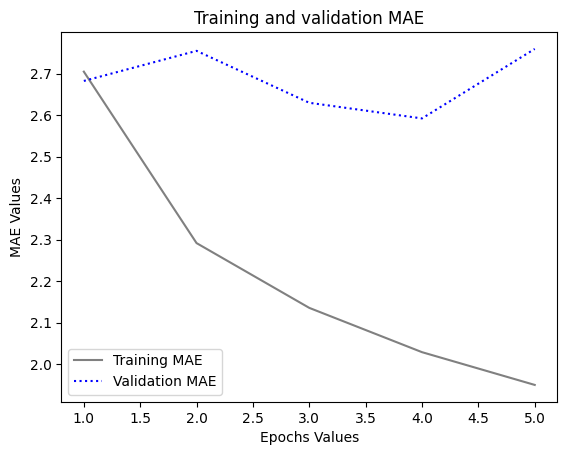

In [19]:
# matplotlib.pyplot for creating plots
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**3rd Model:**


---



***1D convolutional model***

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
convol_x = layers.Conv1D(8, 24, activation="relu")(inputs)     # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 12, activation="relu")(convol_x)   # 1D conventional layer
convol_x = layers.MaxPooling1D(2)(convol_x)                    # Max pooling Layer
convol_x = layers.Conv1D(8, 6, activation="relu")(convol_x)    # 1D conventional layer
convol_x = layers.GlobalAveragePooling1D()(convol_x)
outputs = layers.Dense(1)(convol_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.convol_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.convol_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the MAE of test dataset

Epoch 1/5
819/819 [==============================] - 42s 48ms/step - loss: 25.6978 - mae: 3.9010 - val_loss: 15.4262 - val_mae: 3.1216
Epoch 2/5
819/819 [==============================] - 50s 60ms/step - loss: 15.9845 - mae: 3.1708 - val_loss: 14.8426 - val_mae: 3.0230
Epoch 3/5
819/819 [==============================] - 47s 58ms/step - loss: 14.4231 - mae: 3.0124 - val_loss: 15.5092 - val_mae: 3.1014
Epoch 4/5
819/819 [==============================] - 37s 45ms/step - loss: 13.6848 - mae: 2.9326 - val_loss: 15.4951 - val_mae: 3.0710
Epoch 5/5
405/405 [==============================] - 12s 29ms/step - loss: 16.0210 - mae: 3.1782
Test MAE: 3.18


We received

Validation MAE: 3.2278

Test MAE      : 3.20

**Graph of Training and Validation MAE Values**

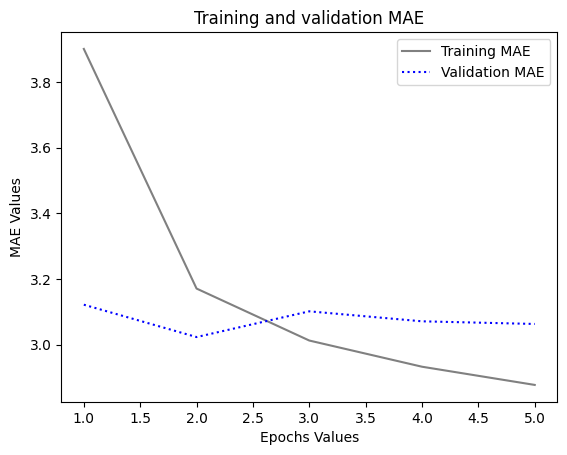

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

The first recurrent baseline

**4th Model:**


---



***Simple LSTM-based model***

In [22]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1])) # Defining the input layer of the model
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 44s 51ms/step - loss: 39.6707 - mae: 4.5454 - val_loss: 11.9123 - val_mae: 2.6243
Epoch 2/5
819/819 [==============================] - 51s 62ms/step - loss: 10.7152 - mae: 2.5508 - val_loss: 9.7320 - val_mae: 2.4117
Epoch 3/5
819/819 [==============================] - 42s 51ms/step - loss: 9.5902 - mae: 2.4140 - val_loss: 9.9988 - val_mae: 2.4348
Epoch 4/5
819/819 [==============================] - 38s 46ms/step - loss: 9.1430 - mae: 2.3536 - val_loss: 10.3955 - val_mae: 2.4836
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 11.0274 - mae: 2.5846
Test MAE: 2.58


We received

Validation MAE: 2.3790

Test MAE      : 2.55

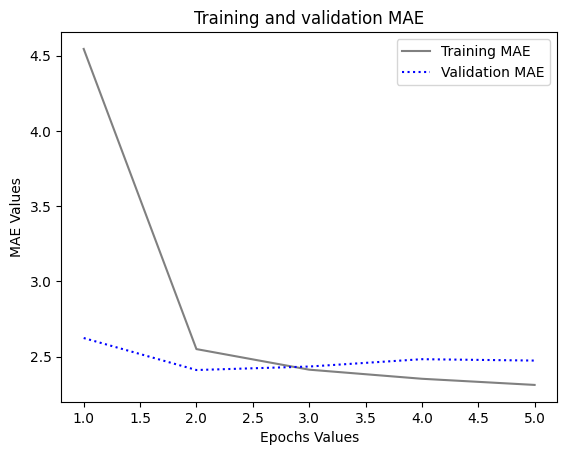

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**5th Model:**


---



***Recurrent neural networks***

**Apllying Numpy to a simple RNN**

In [24]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [25]:
num_features = 14  # Recurring network processing sequences of length
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**RNN layer returning output shape**

In [26]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [27]:
num_features = 14  # Full output sequence retrieval from an RNN layer
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking Of Recurring Neural Network**

In [28]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**6th Model:**


---


***Recurring Neural Network(LSTM Layers)***

***Using recurrent dropout***

**Computing the dropout-regularized LSTM**

In [30]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))              # Defining the input layer of the model
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)  # Using droput function
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # Printing the Test sample MAE

Epoch 1/5
819/819 [==============================] - 310s 371ms/step - loss: 49.2305 - mae: 5.2274 - val_loss: 13.7858 - val_mae: 2.8039
Epoch 2/5
819/819 [==============================] - 285s 348ms/step - loss: 20.2056 - mae: 3.4499 - val_loss: 10.1475 - val_mae: 2.4821
Epoch 3/5
819/819 [==============================] - 287s 350ms/step - loss: 18.1546 - mae: 3.2805 - val_loss: 9.7512 - val_mae: 2.4408
Epoch 4/5
819/819 [==============================] - 288s 351ms/step - loss: 17.1655 - mae: 3.1881 - val_loss: 9.5825 - val_mae: 2.4195
Epoch 5/5
819/819 [==============================] - 287s 350ms/step - loss: 16.4676 - mae: 3.1247 - val_loss: 9.5165 - val_mae: 2.4098


405/405 [==============================] - 27s 65ms/step - loss: 11.0051 - mae: 2.6125
Test MAE: 2.61


We received

Validation MAE: 2.4221

Test MAE : 2.62

 **Graph of dropout-regularized LSTM displaying the validation and training MAE**

In [4]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [2]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs) # Using the LSTM

NameError: name 'keras' is not defined

**7th Model:**


---



***Stacked setup of recurrent layers***

**Computing dropout-regularized, stacked GRU model**

In [1]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))      # Defining the input layer of the model
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specifying a callback list to be utilized in training.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  # Printing the MAE for test dataset

NameError: name 'keras' is not defined

We received

Validation MAE: 2.3444

Test MAE : 2.46

**8th Model:**


---


***Bidirectional RNN***

**Computing the Bidirectional LSTM**

In [3]:
inputs = keras.Input(shape=(sequence_length, pmry_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)                    # Using the Bidirectional function for the model
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")    # Printing The Testing dataset MAE

NameError: name 'keras' is not defined

We received

Validation MAE: 2.5226

Test MAE : 2.60

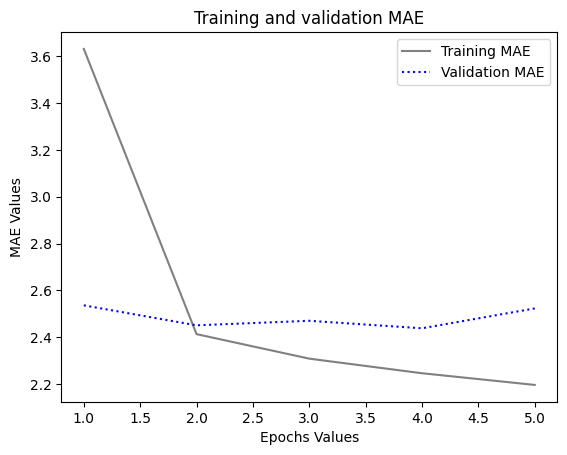

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()

**9th Model:**


---


***Combination Of 1D convent and dropout-regularized LSTM***

In [ ]:
mix_1d_RNN = layers.concatenate([convol_x, lstm_x]) # Using 1D convent and RNN
outputs = layers.Dense(1)(mix_1d_RNN)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}") # Printing the Testing MAE

Epoch 1/5
819/819 [==============================] - 289s 349ms/step - loss: 16.3800 - mae: 3.1180 - val_loss: 9.4154 - val_mae: 2.4084
Epoch 2/5
819/819 [==============================] - 284s 347ms/step - loss: 16.1007 - mae: 3.0890 - val_loss: 9.5428 - val_mae: 2.4194
Epoch 3/5
819/819 [==============================] - 284s 346ms/step - loss: 15.7931 - mae: 3.0641 - val_loss: 9.4338 - val_mae: 2.3982
Epoch 4/5
819/819 [==============================] - 291s 355ms/step - loss: 15.5608 - mae: 3.0405 - val_loss: 9.5251 - val_mae: 2.4140
Epoch 5/5
405/405 [==============================] - 29s 72ms/step - loss: 10.9585 - mae: 2.5953
Test MAE: 2.60


We received

Validation MAE: 2.4410

Test MAE : 2.60

**Graph of Training and Validation MAE of the combination of 1D Convent and RNN**

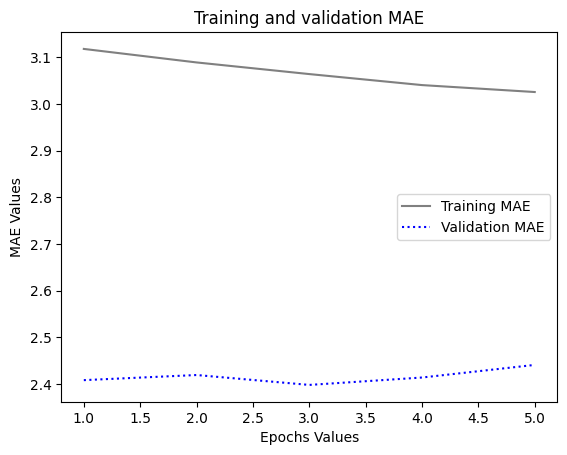

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="solid", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dotted", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs Values")
plt.ylabel("MAE Values")
plt.legend()
plt.show()